In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../analysis_table.csv')


In [7]:
#Check inconsistencies
df_group=df.groupby(['event_name', "lag_event_name"])['time_difference_events'].agg(['median', 'mean', 'count']).reset_index()
print(df_group)

             event_name       lag_event_name  median       mean  count
0    event_name_unknown   event_name_unknown   5.980   5.980000      1
1    event_name_unknown           final_call   3.070   8.962667     15
2    event_name_unknown  on_site_appointment  10.540  16.146000     50
3    event_name_unknown         project_call   9.955  11.172368     38
4            final_call   event_name_unknown   7.925  10.261667     48
5            final_call           final_call   6.940  14.036364     99
6            final_call          first_order  55.385  54.334667     30
7            final_call  on_site_appointment  19.145  25.527579    504
8            final_call         project_call   8.260  11.752172  16220
9   on_site_appointment          first_order  21.680  27.650422  17979
10  on_site_appointment  on_site_appointment   0.030   0.573636     11
11  on_site_appointment         project_call   0.030   0.453711    194
12         project_call           final_call   0.995  14.436600    150
13    

In [ ]:
#Reasoning to keep inconsistencies where lag_event_name is after the event
#Eg(customer_id a93732de06). Reasoning it is ordered by time and the time stamp has final call logged before projetc call but the count of customers in each event category are still correct for funnel
#Eg(customer_idcdd7fb57d5)
df_inconsistencies_order_backwards=df[(df['event_name'] == 'project_call') & (df['lag_event_name']== 'final_call')].sort_values(by='time_difference_events', ascending=False)
df_inconsistencies_order_backwards

In [11]:
#Investigate when huge skip in sequence
#Eg (customer_id 7aa85a6a12). order is not correct. time stap for project call is before appointment. Keep for funnel analysis
df_inconsistencies_skip_sequence=df[(df['event_name'] == 'on_site_appointment') & (df['lag_event_name']== 'project_call')].sort_values(by='time_difference_events', ascending=False)
df_inconsistencies_skip_sequence

,customer_id,event_time,event_name,_source,lag_event_time,time_difference_events,lag_event_name,postal_code_group
39311,8694c13376,2023-10-24 12:15:00,on_site_appointment,appointments_table,2023-10-21 09:00:00,3.14,project_call,4.0
5889,1424c10b46,2023-10-24 11:45:00,on_site_appointment,appointments_table,2023-10-21 08:45:00,3.13,project_call,4.0
7891,1a9abde137,2023-10-24 13:00:00,on_site_appointment,appointments_table,2023-10-21 10:45:00,3.09,project_call,4.0
71722,f6268c712d,2023-10-24 10:45:00,on_site_appointment,appointments_table,2023-10-21 08:45:00,3.08,project_call,4.0
35906,7aa85a6a12,2023-10-24 11:45:00,on_site_appointment,appointments_table,2023-10-21 09:45:00,3.08,project_call,4.0
...,...,...,...,...,...,...,...,...
51559,b06815630c,2023-11-15 12:00:00,on_site_appointment,appointments_table,2023-11-15 12:00:00,0.00,project_call,5.0
52370,b32356efcb,2023-11-15 12:30:00,on_site_appointment,appointments_table,2023-11-15 12:30:00,0.00,project_call,5.0
52488,b3a031b191,2023-11-15 12:45:00,on_site_appointment,appointments_table,2023-11-15 12:45:00,0.00,project_call,5.0
55160,bce29140d6,2023-10-11 10:00:00,on_site_appointment,appointments_table,2023-10-11 10:00:00,0.00,project_call,3.0


In [41]:
df['event_time'] = pd.to_datetime(df['event_time'])
df.sort_values(by=['customer_id', 'event_time'], inplace=True)

# Group by customer and list all events
customer_events = df.groupby('customer_id')['event_name'].apply(list)


In [42]:
#SEE IF PEOPLE WHO REACHED FINAL CALL SKIPPED STEPS
# Customers who have reached 'final_call'
final_call_customers = df[df['event_name'] == 'final_call']['customer_id'].unique()

In [44]:
def check_skipped_steps(events, expected_sequence):
    expected_idx = 0
    for event in events:
        if event in expected_sequence[expected_idx:]:
            next_expected_idx = expected_sequence.index(event, expected_idx) + 1
            if next_expected_idx > expected_idx:
                expected_idx = next_expected_idx
        if event == 'final_call':
            break
    # Check if all expected steps occurred before 'final_call'
    return len(expected_sequence[:expected_idx]) != len(expected_sequence)

# Applying to each customer who reached 'final_call'
skipped_steps = customer_events[customer_events.index.isin(final_call_customers)].apply(lambda events: check_skipped_steps(events, ['first_order','on_site_appointment','project_call', 'final_call']))

In [46]:
customers_who_skipped = skipped_steps[skipped_steps == True]
print(customers_who_skipped)
#END

Series([], Name: event_name, dtype: bool)


In [52]:
#Not considering unknown_events
# Order of funnel
funnel_stages = ['first_order', 'on_site_appointment', 'project_call', 'final_call']

#Empty counts at each stage
funnel_counts = {}

# Filter data progressively
for i, stage in enumerate(funnel_stages):
    if i == 0:
        # Initialize with all users who have at least reached the first stage
        subset = df[df['event_name'] == stage]
    else:
        # Further narrow down to users who reach the next stages
        subset = subset[subset['customer_id'].isin(df[df['event_name'] == stage]['customer_id'])]

    # Store the count of unique users at each stage
    funnel_counts[stage] = subset['customer_id'].nunique()

print(funnel_counts)

{'first_order': 22144, 'on_site_appointment': 18173, 'project_call': 17209, 'final_call': 16455}


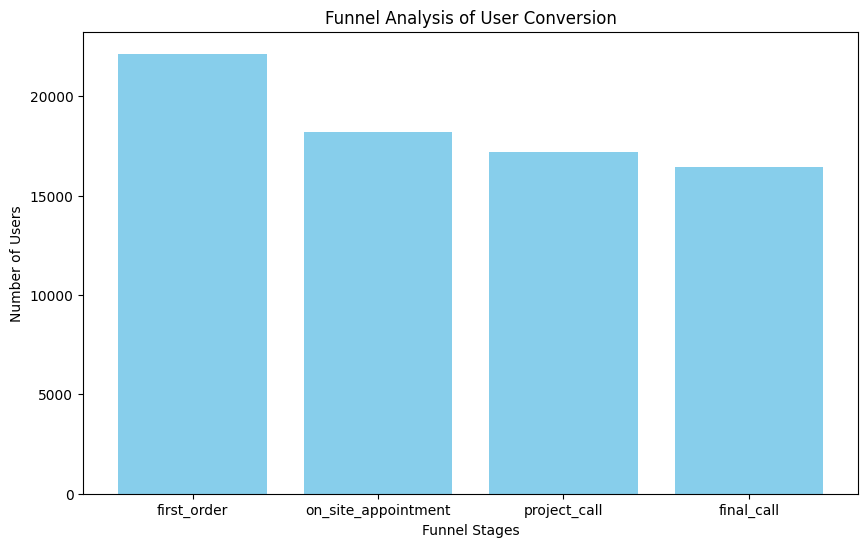

In [53]:
# Plotting the funnel
plt.figure(figsize=(10, 6))
plt.bar(funnel_counts.keys(), funnel_counts.values(), color='skyblue')
plt.xlabel('Funnel Stages')
plt.ylabel('Number of Users')
plt.title('Funnel Analysis of User Conversion')
plt.show()

In [60]:
df_drop_marked=df
stage_customers = {stage: set(df_drop_marked[df_drop_marked['event_name'] == stage]['customer_id']) for stage in funnel_stages}
# Customers who made a first order but did not have an on-site appointment
dropped_out_after_first_order = stage_customers['first_order'].difference(stage_customers['on_site_appointment'])
# Mark customers who dropped out after first order
df_drop_marked['dropped_out_after_first_order'] = df_drop_marked['customer_id'].isin(dropped_out_after_first_order)
print(df_drop_marked.head())


  customer_id          event_time           event_name             _source  \
0  0005cfd259 2023-09-07 01:00:00          first_order        orders_table   
1  0005cfd259 2023-11-27 18:15:00  on_site_appointment  appointments_table   
2  0005cfd259 2023-12-07 13:30:00         project_call  appointments_table   
3  0005cfd259 2023-12-15 11:45:00           final_call  appointments_table   
4  00089e61da 2023-10-31 01:00:00          first_order        orders_table   

        lag_event_time  time_difference_events       lag_event_name  \
0                  NaN                     NaN                  NaN   
1  2023-09-07 01:00:00                   81.72          first_order   
2  2023-11-27 18:15:00                    9.80  on_site_appointment   
3  2023-12-07 13:30:00                    7.93         project_call   
4                  NaN                     NaN                  NaN   

   postal_code_group  dropped_out_after_first_order  
0                6.0                          Fals

In [59]:
dropped_out_customers = df_drop_marked[df_drop_marked['dropped_out_after_first_order'] == True]
dropped_out_customers.head()

,customer_id,event_time,event_name,_source,lag_event_time,time_difference_events,lag_event_name,postal_code_group,dropped_out_after_first_order
60,0035874c63,2023-09-18 01:00:00,first_order,orders_table,NaN,NaN,NaN,1.0,True
65,0038d8c85b,2023-11-01 01:00:00,first_order,orders_table,NaN,NaN,NaN,3.0,True
121,0065667380,2023-09-11 00:00:00,first_order,orders_table,NaN,NaN,NaN,3.0,True
158,0077689014,2023-09-27 01:00:00,first_order,orders_table,NaN,NaN,NaN,2.0,True
177,007e673ee7,2023-11-01 00:00:00,first_order,orders_table,NaN,NaN,NaN,3.0,True
